15:27 - 15:51

In [11]:
import torch

import triton
import triton.language as tl

@triton.jit
def add_kernel(x_ptr, # pointer to first input vector
               y_ptr, # pointer to second input vector
               output_ptr, # pointer to output vector
               n_elements,
               BLOCK_SIZE: tl.constexpr,
               ):
  # there are multiple 'programs' processing different data
  pid = tl.program_id(axis=0) # 1D launch grid
  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE)

  # create a mask to guard memory operations against out-of-bounds accesses
  mask = offsets < n_elements

  # Load x and y from DRAM, masking out any extra elements in case the
  # input is not a multiple of the block size
  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)
  output = x + y

  # write x + y back to DRAM
  tl.store(output_ptr + offsets, output, mask=mask)

helper function to (1) allocate the z tensor and (2) enqueue the above kernel with appropriate grid/block sizes:

In [12]:
torch.tensor([1, 2, 3]).numel()

3

In [13]:
def add(x: torch.Tensor, y: torch.Tensor):
  output = torch.empty_like(x)
  assert x.is_cuda and y.is_cuda and output.is_cuda

  n_elements = output.numel()

  grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

  # Note:
  #  - Each torch.tensor object is implicitly converted into a pointer to its first element
  #  - `triton.jit`ted functions can be indexed with a launch grid to obtain a callable GPU kernel
  add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

  return output

In [14]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is {(output_torch - output_triton).abs().max()}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


## Benchmark

In [ ]:
# byte / ms = byte / ms * 1 GB / 10e9 byte * 10e3 ms / 1sec = GB / s * 10e-6

In [16]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2 ** i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vecor-add-performance',
        args={},
    )
)
def benchmark(size, provider):
  x = torch.rand(size, device='cuda', dtype=torch.float32)
  y = torch.rand(size, device='cuda', dtype=torch.float32)

  quantiles = [0.5, 0.2, 0.8]
  if provider == 'torch':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
  if provider == 'triton':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
  gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
  return gbps(ms), gbps(max_ms), gbps(min_ms)

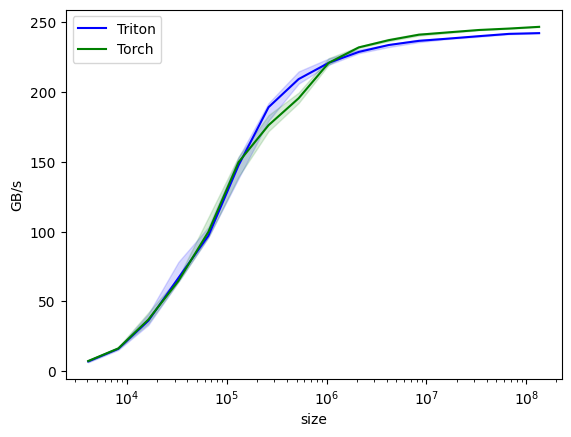

vecor-add-performance:
           size      Triton       Torch
0        4096.0    7.045872    7.366906
1        8192.0   16.083770   16.340425
2       16384.0   36.141177   37.012049
3       32768.0   66.782607   64.673682
4       65536.0   97.138338   99.902435
5      131072.0  147.382306  149.625571
6      262144.0  189.046153  176.172043
7      524288.0  209.157447  195.435392
8     1048576.0  220.783822  220.783822
9     2097152.0  228.613961  231.849058
10    4194304.0  233.570536  237.019900
11    8388608.0  236.520907  240.941181
12   16777216.0  238.168383  242.655723
13   33554432.0  239.889272  244.316530
14   67108864.0  241.538965  245.335931
15  134217728.0  242.068695  246.565422


In [17]:
benchmark.run(print_data=True, show_plots=True)